<a href="https://colab.research.google.com/github/BostonGene-education/MIPT/blob/main/2020/RNA-Seq/03.%20RNA-Seq%20tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://blastim.ru/wp-content/uploads/wpjobboard/company/49/company-logo/bostongene-logo.jpg" width=500 align="center">

# Практикум по анализу RNA-Seq

<b>Автор</b>: Сергей Исаев

## Загрузка прочтений

На лекции мы с вами говорили о базе данных NCBI SRA. Для того, чтобы загружать данные оттуда, необходим специальный пакет программ SRA Toolkit. Этот пакет плохо ставится на Google Colab, поэтому мы загрузим данные из другой большой базы &mdash; <a href="https://www.ebi.ac.uk/arrayexpress/" target="_blank">ArrayExpress</a> при помощи <code>wget</code>.

Из датасета с ID <a href="https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-9724/" target="_blank">E-MTAB-9724</a> загрузим несколько прочтений экспериментов RNA-Seq клеточных линий LUAD (аденокарциномы лёгкого) &mdash; с нокаутом гена <i>STK11</i> и с диким типом. <b>Загрузка прочтений может занять много времени.</b>

In [ ]:
!mkdir raw_reads
!cd raw_reads && mkdir sample_8 sample_9 sample_10 sample_11
!cd raw_reads/sample_8 && wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR478/003/ERR4781423/ERR4781423_1.fastq.gz && wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR478/003/ERR4781423/ERR4781423_2.fastq.gz
!cd raw_reads/sample_9 && wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR478/004/ERR4781424/ERR4781424_1.fastq.gz && wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR478/004/ERR4781424/ERR4781424_2.fastq.gz
!cd raw_reads/sample_10 && wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR478/005/ERR4781425/ERR4781425_1.fastq.gz && wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR478/005/ERR4781425/ERR4781425_2.fastq.gz
!cd raw_reads/sample_11 && wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR478/006/ERR4781426/ERR4781426_1.fastq.gz && wget ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR478/006/ERR4781426/ERR4781426_2.fastq.gz

В папке <code>raw_reads</code> у нас есть подпапки, соответствующие анализируемым экспериментам. В них находятся по два файла &mdash; с прямыми и обратными прочтениями. Сначала нам необходимо установить программы <a href="https://www.bioinformatics.babraham.ac.uk/projects/fastqc/" target="_blank">FastQC</a> и <a href="https://multiqc.info/" target="_blank">MultiQC</a> и провести контроль качества прочтений. Первая программа оценит разнообразные метрики качества ридов каждого образца, вторая &mdash; соберёт все аутпуты FastQC в один красивый. <b>Контроль качества каждого файла занимает по несколько минут.</b>

In [ ]:
!sudo apt install fastqc
!mkdir  raw_reads/fastqc
!fastqc -o raw_reads/fastqc raw_reads/sample_*/*.fastq.gz

На основе получившихся файлов FastQC запускаем MultiQC.

In [ ]:
!pip install multiqc
!mkdir raw_reads/multiqc
!multiqc -o raw_reads/multiqc raw_reads/fastqc/

После этого можно загрузить .html-отчёт о качестве (сейчас он находится в папке <code>raw_reads/multiqc</code>) себе на компьютер и посмотреть, всё ли хорошо с прочтениями. Рассмотрим каждый пункт отчёта:
1. Sequence Quality Histograms
2. Per Sequence Quality Scores
3. <b>Per Base Sequence Content</b> &mdash; проблемы тут связаны с особенностью подготовки библиотеки (использовались случайные праймеры)
4. Per Sequence GC Content
5. Per Base N Content
6. Sequence Length Distribution
7. <b>Sequence Duplication Levels</b> &mdash; в основе порогов данной метрики лежит предположение, что высокое количество дублирующихся прочтений говорит об артефактах ПЦР (это справедливо для, например, геномных библиотек, в которых встретить два одинаковых рида очень маловероятно). Однако для RNA-Seq-экспериментов это нормально, потому что какие-то гены могут встречаться очень часто из-за высокой копийности их РНК (<a href="https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/8%20Duplicate%20Sequences.html" target="_blank">источник</a>)
8. <b>Overrepresented sequences</b> &mdash; проблема вызвана аналогичными седьмому пункту проблемами (<a href="https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/9%20Overrepresented%20Sequences.html" target="_blank">источник</a>)
9. <b>Adapter Content</b> &mdash; мы видим, что у нас в большом числе прочтений содержатся технические адаптеры. Однако почти все современные алгоритмы для работы с RNA-Seq (в т.ч. и kallisto и STAR) автоматически прорабатывают эту проблему, поэтому мануального устранения не требуется (<a href="https://dnatech.genomecenter.ucdavis.edu/faqs/when-should-i-trim-my-illumina-reads-and-how-should-i-do-it/" target="_blank">про то, когда и зачем лучше обрезать адаптеры</a>)

Из этого всего можно сделать вывод, что прочтения у нас хорошие и с ними можно работать.

## Подсчёт экспрессий

Непосредственно оценка экспрессий будет производиться при помощи программы <a href="https://pachterlab.github.io/kallisto/" target="_blank">kallisto</a> (<a href="https://www.nature.com/articles/nbt.3519" target="_blank">Bray et al, 2016</a>). В отличие от других подходов, в kallisto отсутствует стадия выравнивания прочтений на референсный геном или транскриптом. Данный подход строит граф де Брёйна из k-меров транскриптома, после k-меры прочтений образуют пути в этом графе. Основываясь на этих путях, производится максимально правдоподобная оценка экспрессий различных транскриптов.

Подробнее про работу метода можно прочитать <a href="https://bioinfo.iric.ca/understanding-how-kallisto-works/#:~:text=The%20idea%20behind%20kallisto%20is,(not%20the%20whole%20genome)." target="_blank">здесь</a>. Первым шагом мы загрузим kallisto из git-репозитория и установим эту программу.

In [ ]:
!git clone https://github.com/pachterlab/kallisto.git
!apt-get install autoconf
!cd kallisto && mkdir build && cd build && cmake .. && make

Теперь загружаем и распаковываем файл с индексированным транскриптомом. В общем случае можно сгенерировать его самому, однако для человека он уже есть в открытом доступе. Если потребуется сделать индекс самостоятельно, то следует воспользоваться командой <code>kallisto index</code> (команда работает на <b>транскриптоме</b>, а не геноме &mdash; именно из транскриптома строится референсный граф де Брёйна).

In [ ]:
!wget https://github.com/pachterlab/kallisto-transcriptome-indices/releases/download/ensembl-96/homo_sapiens.tar.gz
!tar -xvzf homo_sapiens.tar.gz && rm homo_sapiens.tar.gz

Теперь всё готово к запуску. Итоговые экспрессии положим в папку <code>expression_data</code>. Для начала запустим на одном образце и посмотрим, что у нас получилось. <b>Эта стадия может занять много времени.</b>

In [ ]:
!mkdir expression_data
!./kallisto/build/src/kallisto quant \
    -i homo_sapiens/transcriptome.idx \
    -o expression_data/sample_8 \
    raw_reads/sample_8/ERR4781423_1.fastq.gz raw_reads/sample_8/ERR4781423_2.fastq.gz


[quant] fragment length distribution will be estimated from the data
[index] k-mer length: 31
[index] number of targets: 188,753
[index] number of k-mers: 109,544,288
tcmalloc: large alloc 3221225472 bytes == 0x5596c724a000 @  0x7f1698726887 0x5596c5b72ad2 0x5596c5b6b061 0x5596c5b4004a 0x7f16975a6bf7 0x5596c5b440da
[index] number of equivalence classes: 760,757
[quant] running in paired-end mode
[quant] will process pair 1: raw_reads/sample_8/ERR4781423_1.fastq.gz
                             raw_reads/sample_8/ERR4781423_2.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 29,071,502 reads, 26,150,309 reads pseudoaligned
[quant] estimated average fragment length: 227.52
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 1,290 rounds



Посмотрим, что хранится в файле <code>abundance.tsv</code> в папке <code>expression_data/sample_8/</code>. Для этого выведем строки с 990 по 1000, а также первую (с заголовком).

In [ ]:
!head -n 1 expression_data/sample_8/abundance.tsv | tail -n 10
!head -n 1000 expression_data/sample_8/abundance.tsv | tail -n 10

target_id	length	eff_length	est_counts	tpm
ENST00000617210.4	1547	1320.48	0	0
ENST00000611450.1	1358	1131.48	0	0
ENST00000616910.4	2886	2659.48	58.9113	1.21791
ENST00000613528.4	4138	3911.48	4.12069	0.0579217
ENST00000611667.1	2765	2538.48	0	0
ENST00000620720.3	711	485.355	2108.56	238.857
ENST00000625297.1	476	260.075	3.05918	0.646725
ENST00000610406.1	353	159.059	72.4051	25.0279
ENST00000618740.4	3421	3194.48	0	0
ENST00000615699.1	3250	3023.48	0	0


Видно, что напротив каждого <code>target_id</code> в конце строки стоят колонки <code>est_counts</code> и <code>tpm</code>. Это и есть наши уровни экспрессии. Важно, что, в отличие от результатов работы HTSeq и прочих алгоритмов подсчёта экспрессии, основанных на выравнивании, kallisto <b>оценивает</b> представленность транскриптов, а не физически считает их. Поэтому число ридов на транскрипт <code>est_counts</code> может быть <b>нецелым</b> (позже мы просто округлим его). Проверим, правда ли сумма значений в колонке <code>tpm</code> равна миллиону, а также соответствует ли сумма <code>est_counts</code> числу прочтений из изначального .fastq-файла (для восьмого образца это в районе 29 миллионов, число взято из репорта MultiQC).

In [ ]:
import pandas as pd

sample8_kallisto_output = pd.read_csv("expression_data/sample_8/abundance.tsv",
                                      sep="\t", index_col=0)
tpm_sum = sample8_kallisto_output.tpm.sum()
count_sum = sample8_kallisto_output.est_counts.sum()

print("Counts: {}\nTPM: {}".format(tpm_sum, count_sum))

Counts: 999999.890942333
TPM: 26150307.8847599


Разница в почти три миллиона прочтений. Однако не стоит бояться, это просто неоткартировавшиеся прочтения &mdash; такое их число нормально для эксперимента. Давайте тогда проведём анализ и с оставшимися образцами.

In [ ]:
!./kallisto/build/src/kallisto quant \
    -i homo_sapiens/transcriptome.idx \
    -o expression_data/sample_9 \
    raw_reads/sample_9/ERR4781424_1.fastq.gz raw_reads/sample_9/ERR4781424_2.fastq.gz
!./kallisto/build/src/kallisto quant \
    -i homo_sapiens/transcriptome.idx \
    -o expression_data/sample_10 \
    raw_reads/sample_10/ERR4781425_1.fastq.gz raw_reads/sample_10/ERR4781425_2.fastq.gz
!./kallisto/build/src/kallisto quant \
    -i homo_sapiens/transcriptome.idx \
    -o expression_data/sample_11 \
    raw_reads/sample_11/ERR4781426_1.fastq.gz raw_reads/sample_11/ERR4781426_2.fastq.gz

Склеим все обсчитанные экспрессии в одну сводную сводную таблицу.

In [ ]:
expressions_counts = pd.concat(
    [pd.read_csv(
        "expression_data/{}/abundance.tsv".format(expression),
        sep="\t", index_col=0, header=0, usecols=["target_id", expression],
        names=["target_id", "1", "2", expression, "3"]
    ) for expression in ["sample_8", "sample_9", "sample_10", "sample_11"]],
    axis=1, join="inner"
)
expressions_counts.columns = ["sample_8", "sample_9", "sample_10", "sample_11"]
expressions_counts.head()

,sample_8,sample_9,sample_10,sample_11
target_id,,,,
ENST00000631435.1,0.0,0.0,0.0,0.0
ENST00000434970.2,0.0,0.0,0.0,0.0
ENST00000448914.1,0.0,0.0,0.0,0.0
ENST00000415118.1,0.0,0.0,0.0,0.0
ENST00000632684.1,0.0,0.0,0.0,0.0


## Анализ экспрессий

На этом шаге мы будем искать дифференциально экспрессированные между образцами транскрипты.

### rpy2

Из-за того, что анализ дифференциальной экспрессии в основном написан для R, мы будем пользоваться пакетом rpy2, чтобы выполнять код R в Python.

In [ ]:
import rpy2
from rpy2.robjects import r, pandas2ri

%load_ext rpy2.ipython
pandas2ri.activate()

Вот таким образом выглядит ячейка, которая будет выполняться как R-скрипт:

In [ ]:
%%R
a <- c(1,2,3)
a <- a**2
print(a)

[1] 1 4 9


Для того, чтобы объекты из окружения R попали в окружение Python (и наоборот), необходимо выполнить следующее:

In [ ]:
a = 20
%R -i a
%R a <- a**2
%R -o a
print(a, type(a))

[400.] <class 'numpy.ndarray'>


Если хочется более полно овладеть rpy2, то лучше прочитайте <a href="https://rpy2.github.io/doc/latest/html/index.html" target="_blank">его документацию</a>.

### Анализ дифференциальной экспрессии при помощи DESeq2

Сейчас мы установим <a href="http://bioconductor.org/packages/release/bioc/html/DESeq2.html" target="_blank">DESeq2</a> (<a href="https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8" target="_blank">Love et al, 2014</a>) в наше окружение. Этот пакет нужен для параметрического анализа дифференциальной экспрессии и использует обобщённые линейные модели. На вход он получает матрицу с <b>ненормированными</b> каунтами (не TPM и не RPKM). <b>Установка DESeq2 может занять несколько минут.</b>

In [ ]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2")

library("DESeq2")
library(ggplot2)

In [ ]:
%%R
library("DESeq2")
library(ggplot2)

Далее мы перегружаем наш датафрейм из Python в R, чтобы  работать с ним там. Округлим наши экспрессии, чтобы они стали целочисленными (DESeq2 не умеет работать с нецелыми значениями каунтов) &mdash; для этого жёстко обозначим тип данных экспрессии как <code>int32</code>. Также во время портирования в R теряется индекс датафрейма (ID транскриптов), поэтому сохраним его в отдельную переменную.

In [ ]:
expr_matrix = expressions_counts.copy()
expr_matrix = expr_matrix.astype("int32")
expr_matrix.index.name = ""
gene_id = expr_matrix.index.copy()
%R -i expr_matrix
%R -i gene_id

In [ ]:
%%R
rownames(expr_matrix) = make.names(gene_id, unique=TRUE)
head(expr_matrix)

                  sample_8 sample_9 sample_10 sample_11
ENST00000631435.1        0        0         0         0
ENST00000434970.2        0        0         0         0
ENST00000448914.1        0        0         0         0
ENST00000415118.1        0        0         0         0
ENST00000632684.1        0        0         0         0
ENST00000604446.1        0        0         0         0


Видим, что в переменной <code>expr_matrix</code> в R содержится то же, что и в переменной <code>expressions_counts</code> в Python.

Теперь необходимо создать <b>аннотацию</b> (переменная <code>colData</code> для каждого семпла). Аннотация представляет из себя ещё один датафрейм. В нём чисто столбцов совпадает с числом столбцов в датафрейме с экспрессиями, а помимо названий образцов там у нас будут различные <b>мета-данные</b>, в том числе и те, которые будут разделять образцы для дальнейшей дифференциальной экспрессии (у нас это будет условием <code>condition</code> с двумя возможными значениями &mdash; WT и Mut).

После из датафреймов <code>expr_matrix</code> и <code>conditions</code> мы сделаем новую переменную <code>dds</code> специального типа, который используется при работе в <code>DESeq2</code>. Также во время создания объекта DESeqDataSet мы указываем условие, по которому будем считать дифференциальную экспрессию. Важно иметь в виду, что модель может оценивать дифференциальную экспрессию в зависимости от сразу нескольких факторов, которые могут быть в том числе и количественные.

In [ ]:
%%R
condition <- c("WT", "WT", "Mut", "Mut")
name <- c("sample_8", "sample_9", "sample_10", "sample_11")
colData <- data.frame(condition, name)
dds <- DESeqDataSetFromMatrix(expr_matrix, colData, design=~condition)
print(dds)

class: DESeqDataSet 
dim: 188753 4 
metadata(1): version
assays(1): counts
rownames(188753): ENST00000631435.1 ENST00000434970.2 ...
  ENST00000646356.1 ENST00000645792.1
rowData names(0):
colnames(4): sample_8 sample_9 sample_10 sample_11
colData names(2): condition name


Мы получили специальный объект класса <code>DESeqDataSet</code>. На нём мы выполним функцию <code>DESeq</code>, которая реализует весь пайплайн анализа дифференциальной экспрессии.

In [ ]:
%%R
dds <- DESeq(dds)

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



Посмотрим, что поменялось в переменной <code>dds</code>.

In [ ]:
%%R
print(dds)

class: DESeqDataSet 
dim: 188753 4 
metadata(1): version
assays(4): counts mu H cooks
rownames(188753): ENST00000631435.1 ENST00000434970.2 ...
  ENST00000646356.1 ENST00000645792.1
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(4): sample_8 sample_9 sample_10 sample_11
colData names(3): condition name sizeFactor


Определим, какие же из транскриптов дифференциально экспрессированы между диким типом и мутантами. Сначала выведем статистику по каждому транскрипту.

In [ ]:
%%R
res <- results(dds)
head(results(dds))

log2 fold change (MLE): condition WT vs Mut 
Wald test p-value: condition WT vs Mut 
DataFrame with 6 rows and 6 columns
                   baseMean log2FoldChange     lfcSE      stat    pvalue
                  <numeric>      <numeric> <numeric> <numeric> <numeric>
ENST00000631435.1         0             NA        NA        NA        NA
ENST00000434970.2         0             NA        NA        NA        NA
ENST00000448914.1         0             NA        NA        NA        NA
ENST00000415118.1         0             NA        NA        NA        NA
ENST00000632684.1         0             NA        NA        NA        NA
ENST00000604446.1         0             NA        NA        NA        NA
                       padj
                  <numeric>
ENST00000631435.1        NA
ENST00000434970.2        NA
ENST00000448914.1        NA
ENST00000415118.1        NA
ENST00000632684.1        NA
ENST00000604446.1        NA


Значения NA у нас возникают у генов, которые никак не экспрессированы ни в одном образце (это нормально для человека). Упорядочим гены по p-value<sub>adj</sub>.

In [ ]:
%%R
res <- res[order(res$padj),]
head(res)

log2 fold change (MLE): condition WT vs Mut 
Wald test p-value: condition WT vs Mut 
DataFrame with 6 rows and 6 columns
                   baseMean log2FoldChange     lfcSE      stat      pvalue
                  <numeric>      <numeric> <numeric> <numeric>   <numeric>
ENST00000307407.8  1561.749       -5.52799  0.396153 -13.95416 2.96770e-44
ENST00000336916.8 37946.947        2.82916  0.251364  11.25520 2.18335e-29
ENST00000317376.8   442.651        4.87089  0.433865  11.22674 3.01382e-29
ENST00000330722.7   747.750       -3.74591  0.384527  -9.74159 2.00385e-22
ENST00000436759.6   513.763       10.07369  1.078946   9.33661 9.94685e-21
ENST00000264563.7  3768.118       -2.11135  0.226487  -9.32214 1.14020e-20
                         padj
                    <numeric>
ENST00000307407.8 1.55956e-39
ENST00000336916.8 5.27930e-25
ENST00000317376.8 5.27930e-25
ENST00000330722.7 2.63261e-18
ENST00000436759.6 8.55981e-17
ENST00000264563.7 8.55981e-17


Теперь можно визуализировать разницу между самыми различающимися транскриптами. При помощи функции DESeq2 <code>plotCounts</code> отобразим наглядно, какие уровни экспрессии у самым дифференциально экспрессированных транскриптов в обоих условиях.

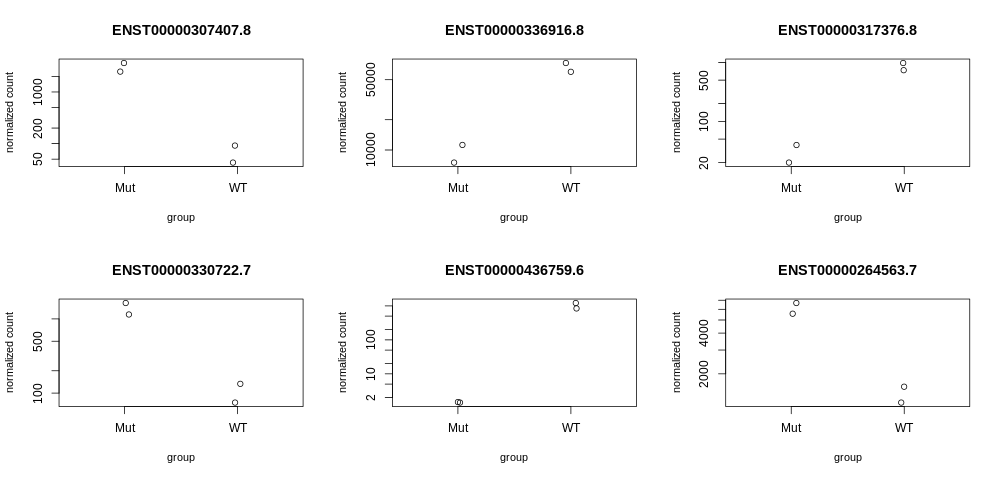

In [ ]:
%%R -w 1000
#Задаём размер текста и композицию графика
par(mfrow=c(2,3), cex=1.0, cex.main=1.2, cex.axis=1, cex.lab=0.9)

plotCounts(dds, gene="ENST00000307407.8", intgroup="condition")
plotCounts(dds, gene="ENST00000336916.8", intgroup="condition")
plotCounts(dds, gene="ENST00000317376.8", intgroup="condition")
plotCounts(dds, gene="ENST00000330722.7", intgroup="condition")
plotCounts(dds, gene="ENST00000436759.6", intgroup="condition")
plotCounts(dds, gene="ENST00000264563.7", intgroup="condition")

Построим по нашим результатам VolcanoPlot стандартными методами <code>ggplo2</code>. Вообще, для этого есть удобный пакет <code>EnhancedVolcano</code>, однако через rpy2 он не работает.

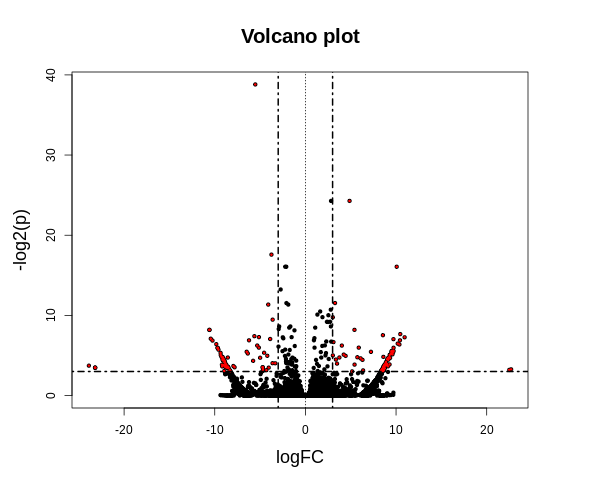

In [97]:
%%R -w 600

#Задаём размер текста и композицию графика
par(mar=c(5,5,5,5), cex=1.0, cex.main=1.7, cex.axis=1, cex.lab=1.5)

#Отрисовываем все точки чёрным цветом
with(res, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", cex=1.0, xlab="logFC", ylab="-log2(p)"))

#Отрисовываем точки, прошедшие порог, красным цветом
with(subset(res, padj<0.001 & abs(log2FoldChange)>3), points(log2FoldChange, -log10(padj), pch=20, col="red", cex=0.5))

#Отрисовываем линии с порогами
abline(v=0, col="black", lty=3, lwd=1.0)
abline(v=-3, col="black", lty=4, lwd=2.0)
abline(v=3, col="black", lty=4, lwd=2.0)
abline(h=3, col="black", lty=4, lwd=2.0)

# Домашнее задание

<b>Дедлайн</b>: 9 ноября, 23:59

<b>Форма отчёта</b>: ссылка на ноутбук в Google Colab или в вашем личном GitHub-репозитории. В ноутбуке должен быть воспроизводимый код, а также ответы на поставленные вопросы.

## Задание 1

Напишите функцию, которая будет принимать на вход матрицу экспрессий в TPM, а выводить матрицу экспрессий в RPKM.

In [ ]:
def TPM_to_RPKM(TPMs):
  """
  This function return a dataframe with expressions in RPKM

  :TPMs: dataframe with expressions in TPM
  """

  # Вставьте ваш код здесь
  
  return RPKMs

## Задание 2

До этого мы с вами работали на уровне транскриптов. Однако транскрипты сами по себе мало о чём нам говорят &mdash; нам интересно посмотреть, какие гены дифференциально экспрессированы. Для этого перед тем, как анализировать дифференциальную экспрессию, преобразуйте таблицу с экспрессиями &mdash; сложите каунты транскриптов, относящихмя к одному гену, и из сумм создайте новую таблицу. Вместо Ensembl ID генов (<code>ENSGXXXX</code>) используйте их названия (<code>gene symbol</code>). После того, как вы составите новую таблицу, повторите проведённый выше анализ. Сравните количество дифференциально экспрессированных транскриптов и дифференциально экспрессированных генов (с p<sub>adj</sub> < 0.01 и logFC > 2).

<i>Подсказка: соотнесение транскриптов к генам можно найти в папке с индексом kallisto (однако там почему-то есть не все гены). Также вы можете для ваших целей использовать пакет </i><code>myGene</code><i> на Python 3. Также рекомендуем написать функцию, которая будет одну таблицу трансформировать в другую &mdash; это понадобится вам для следующего задания.</i>

In [ ]:
def transcripts_to_genes(transcripts):
  """
  This function return a dataframe with gene-level expressions

  :transcripts: dataframe with transcript-level expression
  """

  # Вставьте ваш код здесь
  
  return genes

In [ ]:
# Вставьте ваш код здесь

## Задание 3

Загрузите прочтения ещё четырёх образцов из исследования &mdash; две линии с нокаутом <i>KEAP1</i>, а также две линии с наукаутом по обоим генам. Выполните обработку, аналогичную той, которую мы делали на занятии: посмотрите на дифференциально экспрессированные гены для (1) просто нокаутов по <i>KEAP1</i> и для (2) нокаутов по обоим генам. <b>Дифференциальную экспрессию рассчитывайте на уровне генов, а не транскриптов.</b>

Являются ли дифференциально экспрессированные гены во втором случае объединением дифференциально экспрессированных генов по нокаутом <i>KEAP1</i> и <i>STK11</i>? Почему?

In [ ]:
# Вставьте ваш код здесь

## Задание 4<sup>*</sup>

Снизьте размерность транскрипционных профилей образцов при помощи метода клавных компонент. Постройте график по первым двум компонентам из PCA. Как именно это делается можно прочитать <a href="https://www.machinelearningmastery.ru/pca-using-python-scikit-learn-e653f8989e60/" target="_blank">тут</a> (в R это делается одной функцией <code>prcomp</code>). Объясните получившиеся результаты.

In [ ]:
# Вставьте ваш код здесь